In [64]:
import pandas as pd
import numpy as np
import requests
import math
from scipy import stats
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.api as smt
from statsmodels.tsa.api import VAR
from statsmodels.stats.stattools import durbin_watson
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [65]:
DAX = pd.read_csv('../Data/DAX.csv')
VOO = pd.read_csv('../Data/VOO.csv')

In [66]:
DAX

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-04,25.910000,25.910000,25.612000,25.700001,25.041664,2800
1,2019-03-05,25.731001,25.731001,25.700001,25.700001,25.041664,500
2,2019-03-06,25.780001,25.780001,25.650000,25.660000,25.002687,700
3,2019-03-07,25.240000,25.299999,25.230000,25.231001,24.584679,7400
4,2019-03-08,25.191000,25.191000,25.191000,25.191000,24.545704,400
...,...,...,...,...,...,...,...
249,2020-02-27,25.620001,26.003000,25.209999,25.209999,25.209999,10700
250,2020-02-28,24.510000,24.995001,24.473000,24.950001,24.950001,6400
251,2020-03-02,25.090000,25.420000,24.905001,25.360001,25.360001,3600
252,2020-03-03,25.719999,25.750000,25.000000,25.091000,25.091000,4900


In [67]:
VOO

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-04,258.869995,259.100006,254.490005,256.839996,251.658798,3384200
1,2019-03-05,256.989990,257.170013,255.960007,256.540009,251.364868,2475900
2,2019-03-06,256.619995,256.619995,254.600006,254.899994,249.757950,2514900
3,2019-03-07,254.479996,254.600006,251.949997,252.850006,247.749298,6441200
4,2019-03-08,250.880005,252.449997,250.339996,252.339996,247.249573,4522300
...,...,...,...,...,...,...,...
249,2020-02-27,280.570007,284.480011,273.359985,273.390015,273.390015,14897000
250,2020-02-28,265.320007,272.920013,262.250000,271.739990,271.739990,23324100
251,2020-03-02,274.000000,284.040009,270.489990,283.869995,283.869995,12428600
252,2020-03-03,284.339996,288.320007,273.359985,276.040009,276.040009,9766400


In [68]:
DAX['Date'] = pd.to_datetime(DAX['Date'])
DAX

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-04,25.910000,25.910000,25.612000,25.700001,25.041664,2800
1,2019-03-05,25.731001,25.731001,25.700001,25.700001,25.041664,500
2,2019-03-06,25.780001,25.780001,25.650000,25.660000,25.002687,700
3,2019-03-07,25.240000,25.299999,25.230000,25.231001,24.584679,7400
4,2019-03-08,25.191000,25.191000,25.191000,25.191000,24.545704,400
...,...,...,...,...,...,...,...
249,2020-02-27,25.620001,26.003000,25.209999,25.209999,25.209999,10700
250,2020-02-28,24.510000,24.995001,24.473000,24.950001,24.950001,6400
251,2020-03-02,25.090000,25.420000,24.905001,25.360001,25.360001,3600
252,2020-03-03,25.719999,25.750000,25.000000,25.091000,25.091000,4900


In [69]:
VOO['Date'] = pd.to_datetime(VOO['Date'])
VOO

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-04,258.869995,259.100006,254.490005,256.839996,251.658798,3384200
1,2019-03-05,256.989990,257.170013,255.960007,256.540009,251.364868,2475900
2,2019-03-06,256.619995,256.619995,254.600006,254.899994,249.757950,2514900
3,2019-03-07,254.479996,254.600006,251.949997,252.850006,247.749298,6441200
4,2019-03-08,250.880005,252.449997,250.339996,252.339996,247.249573,4522300
...,...,...,...,...,...,...,...
249,2020-02-27,280.570007,284.480011,273.359985,273.390015,273.390015,14897000
250,2020-02-28,265.320007,272.920013,262.250000,271.739990,271.739990,23324100
251,2020-03-02,274.000000,284.040009,270.489990,283.869995,283.869995,12428600
252,2020-03-03,284.339996,288.320007,273.359985,276.040009,276.040009,9766400


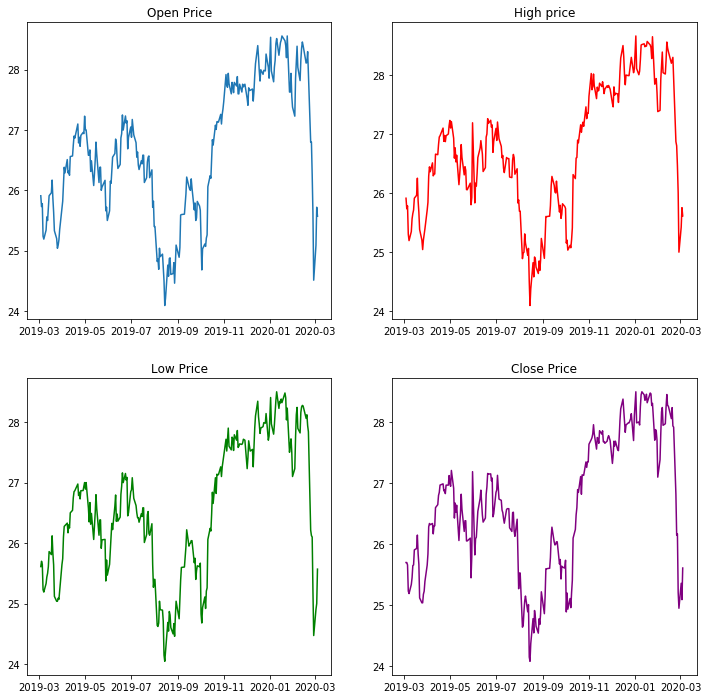

In [70]:
# Plot de los datos de DAX
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(12,12))
axes[0,0].plot(DAX['Date'], DAX['Open'])
axes[0,0].set_title('Open Price')
axes[0,1].plot(DAX['Date'],DAX['High'], color='red')
axes[0,1].set_title('High price')
axes[1,0].plot(DAX['Date'], DAX['Low'], color='green')
axes[1,0].set_title('Low Price')
axes[1,1].plot(DAX['Date'],DAX['Close'], color='purple')
axes[1,1].set_title('Close Price')
plt.savefig('../images/DAXOriginal.png')
plt.show()

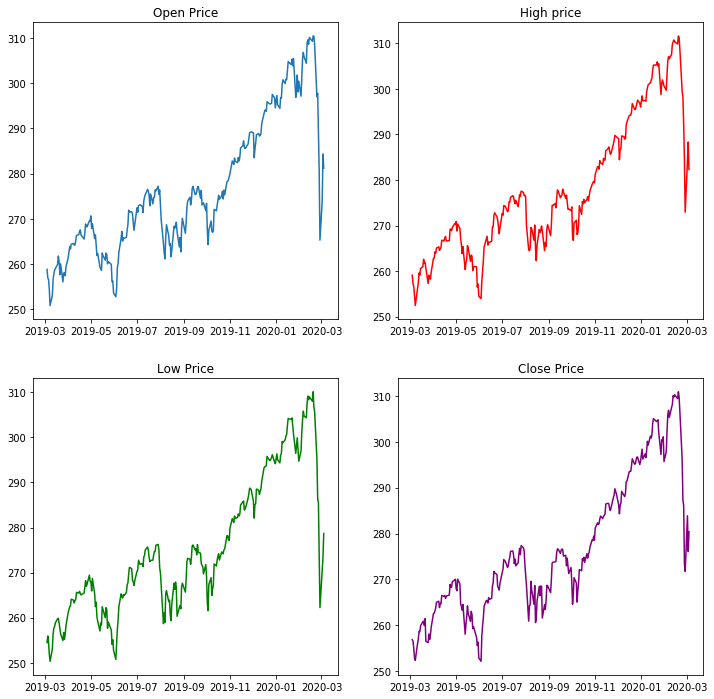

In [71]:
# plot de los datos de VOO
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(12,12))
axes[0,0].plot(VOO['Date'], VOO['Open'])
axes[0,0].set_title('Open Price')
axes[0,1].plot(VOO['Date'],VOO['High'], color='red')
axes[0,1].set_title('High price')
axes[1,0].plot(VOO['Date'], VOO['Low'], color='green')
axes[1,0].set_title('Low Price')
axes[1,1].plot(VOO['Date'],VOO['Close'], color='purple')
axes[1,1].set_title('Close Price')
plt.savefig('../images/VOO_Original.png')
plt.show()

In [72]:
# Muestra si el datase es una distribucion normal, si el pvalue es mayor que el 5% entonces la distribucion no es normal
def norm_dist(tested):
    nh = 0.05
    Stats, p = stats.normaltest(tested)
    print('Statistic: ', Stats, 'Pvalue: ', p)
    if p > nh:
        return 'El dataset es una distribucion normal'
    else:
        return 'El dataset no es una distribucion normal'
    
    


In [73]:
norm_dist(DAX['Open'])

Statistic:  34.676928898442306 Pvalue:  2.9512130662629512e-08


'El dataset no es una distribucion normal'

In [74]:
norm_dist(VOO['Open'])

Statistic:  21.240197536841993 Pvalue:  2.442022761647952e-05


'El dataset no es una distribucion normal'

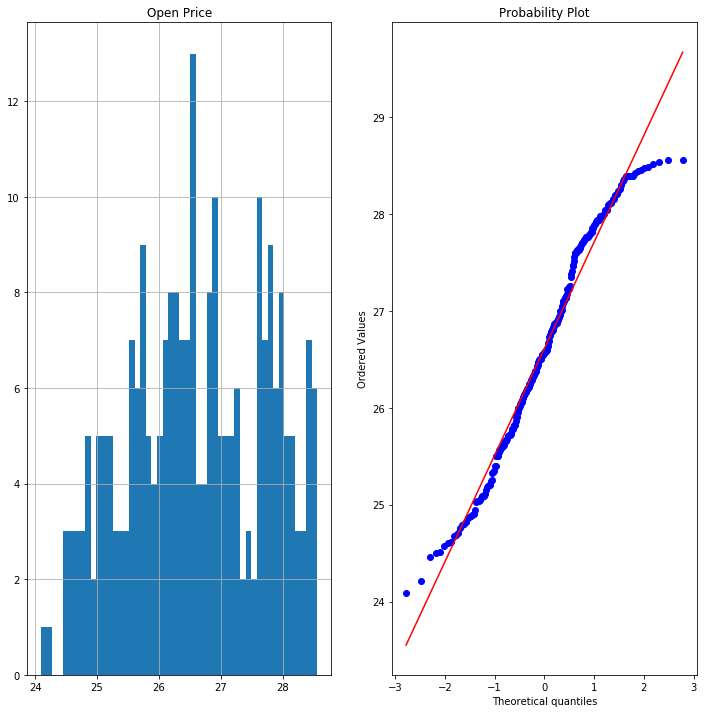

In [75]:
# Ploteo de el histograma de los datos, donde se muestra la concentracion principal de precios y 
# los cuantiles teoricos que ademas muestran la con una linea roja la mejor opcion de prediccion para los datos
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
DAX['Open'].hist(bins=50)
plt.title('Open Price')
plt.subplot(1,2,2)
stats.probplot(DAX['Open'],plot=plt)
plt.savefig('../images/DAXHistProb.png')
plt.show()

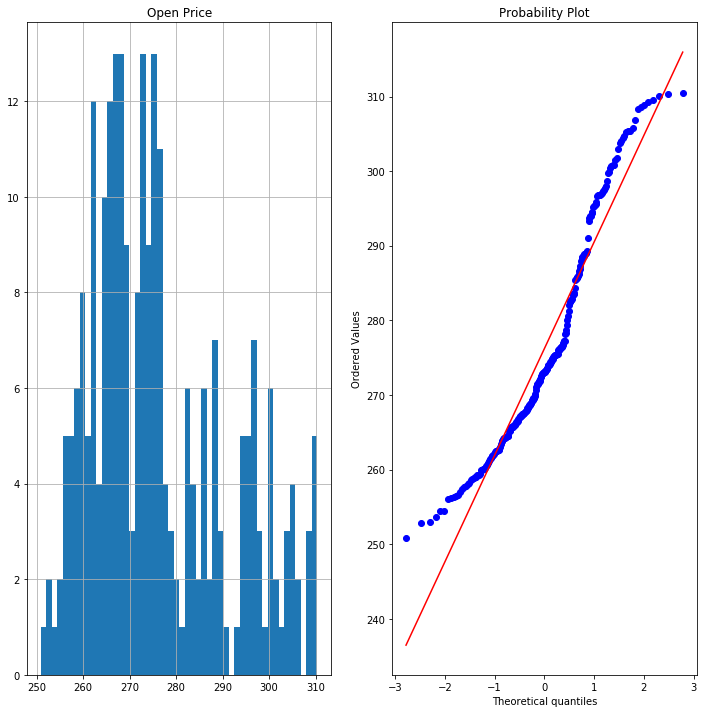

In [76]:
# plot de concentracion de los precios y un plot de la probabilidad con 
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
VOO['Open'].hist(bins=50)
plt.title('Open Price')
plt.subplot(1,2,2)
stats.probplot(VOO['Open'],plot=plt)
plt.savefig('../images/VOOHistProb.png')
plt.show()

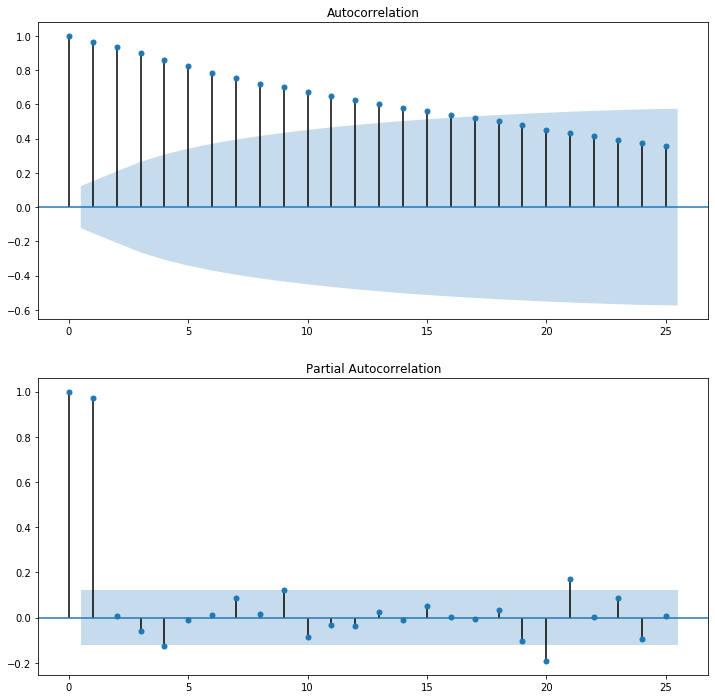

In [77]:
# Muestra la correlacion y la correlacion parcial de los datos para DAX
fig, axes = plt.subplots(2,figsize=(12,12))
axes[0] = plot_acf(DAX['Open'], ax=axes[0])
axes[1] = plot_pacf(DAX['Open'], ax=axes[1])
plt.savefig('../images/DAXPartAutocorr.png')

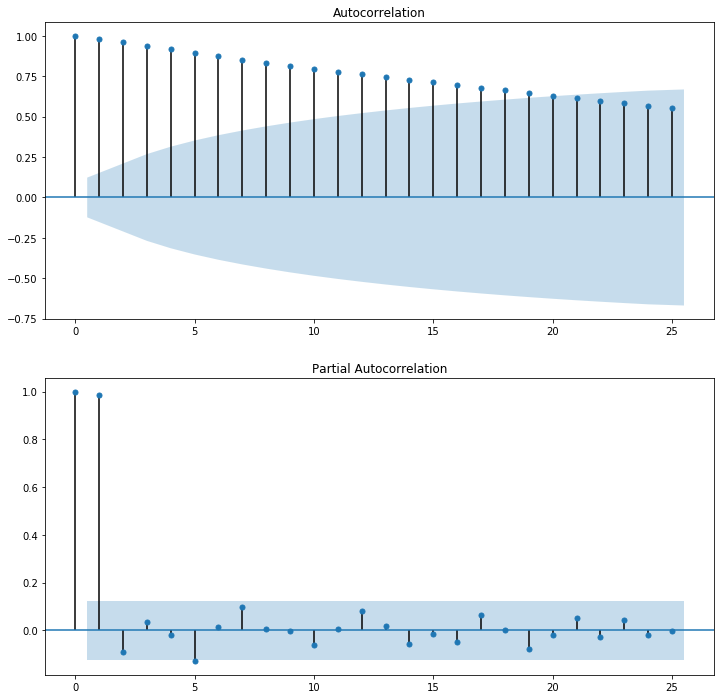

In [78]:
# Autocorrelacion y correlacion parcial de los datos de VOO
fig, axes = plt.subplots(2,figsize=(12,12))
axes[0] = plot_acf(VOO['Open'], ax=axes[0])
axes[1] = plot_pacf(VOO['Open'], ax=axes[1])
plt.savefig('../images/VOOPartAutocorr.png')

In [79]:
# definiendo el training y el test para DAX
X_train_DAX, X_test_DAX = DAX[0:-15], DAX[-15:]

In [80]:
# definiendo el training y el test para VOO
X_train_VOO, X_test_VOO = VOO[0:-15], VOO[-15:]

In [81]:
print('Train shape: ', X_train_DAX.shape, 'Test shape: ', X_test_DAX.shape)

Train shape:  (239, 7) Test shape:  (15, 7)


In [82]:
# Convirtiendo los datos a estacionarios para DAX
transform_data_DAX = DAX[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].diff().dropna()
transform_data_DAX

,Open,High,Low,Close,Adj Close,Volume
1,-0.178999,-0.178999,0.088001,0.000000,0.000000,-2300.0
2,0.049000,0.049000,-0.050001,-0.040001,-0.038977,200.0
3,-0.540001,-0.480002,-0.420000,-0.428999,-0.418008,6700.0
4,-0.049000,-0.108999,-0.039000,-0.040001,-0.038975,-7000.0
5,0.149000,0.153999,0.139999,0.149000,0.145182,2100.0
...,...,...,...,...,...,...
249,-0.639999,-0.461001,-0.890001,-0.960001,-0.960001,7400.0
250,-1.110001,-1.007999,-0.736999,-0.259998,-0.259998,-4300.0
251,0.580000,0.424999,0.432001,0.410000,0.410000,-2800.0
252,0.629999,0.330000,0.094999,-0.269001,-0.269001,1300.0


In [83]:
# Convirtiendo los datos a estacionarios para VOO
transform_data_VOO = VOO[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].diff().dropna()
transform_data_VOO

,Open,High,Low,Close,Adj Close,Volume
1,-1.880005,-1.929993,1.470002,-0.299987,-0.293930,-908300.0
2,-0.369995,-0.550018,-1.360001,-1.640015,-1.606918,39000.0
3,-2.139999,-2.019989,-2.650009,-2.049988,-2.008652,3926300.0
4,-3.599991,-2.150009,-1.610001,-0.510010,-0.499725,-1918900.0
5,2.159988,3.669998,2.680008,3.679993,3.605774,-2638100.0
...,...,...,...,...,...,...
249,-8.039978,-7.799988,-12.120026,-12.679992,-12.679992,4663300.0
250,-15.250000,-11.559998,-11.109985,-1.650025,-1.650025,8427100.0
251,8.679993,11.119996,8.239990,12.130005,12.130005,-10895500.0
252,10.339996,4.279998,2.869995,-7.829986,-7.829986,-2662200.0


In [84]:
# agregando la columan fecha para los dato de DAX
concat_data_DAX = transform_data_DAX.join(DAX['Date'])
concat_data_DAX

,Open,High,Low,Close,Adj Close,Volume,Date
1,-0.178999,-0.178999,0.088001,0.000000,0.000000,-2300.0,2019-03-05
2,0.049000,0.049000,-0.050001,-0.040001,-0.038977,200.0,2019-03-06
3,-0.540001,-0.480002,-0.420000,-0.428999,-0.418008,6700.0,2019-03-07
4,-0.049000,-0.108999,-0.039000,-0.040001,-0.038975,-7000.0,2019-03-08
5,0.149000,0.153999,0.139999,0.149000,0.145182,2100.0,2019-03-11
...,...,...,...,...,...,...,...
249,-0.639999,-0.461001,-0.890001,-0.960001,-0.960001,7400.0,2020-02-27
250,-1.110001,-1.007999,-0.736999,-0.259998,-0.259998,-4300.0,2020-02-28
251,0.580000,0.424999,0.432001,0.410000,0.410000,-2800.0,2020-03-02
252,0.629999,0.330000,0.094999,-0.269001,-0.269001,1300.0,2020-03-03


In [85]:
# Reorganizando las columnas para DAX
concat_data_DAX = concat_data_DAX[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
concat_data_DAX

,Date,Open,High,Low,Close,Adj Close,Volume
1,2019-03-05,-0.178999,-0.178999,0.088001,0.000000,0.000000,-2300.0
2,2019-03-06,0.049000,0.049000,-0.050001,-0.040001,-0.038977,200.0
3,2019-03-07,-0.540001,-0.480002,-0.420000,-0.428999,-0.418008,6700.0
4,2019-03-08,-0.049000,-0.108999,-0.039000,-0.040001,-0.038975,-7000.0
5,2019-03-11,0.149000,0.153999,0.139999,0.149000,0.145182,2100.0
...,...,...,...,...,...,...,...
249,2020-02-27,-0.639999,-0.461001,-0.890001,-0.960001,-0.960001,7400.0
250,2020-02-28,-1.110001,-1.007999,-0.736999,-0.259998,-0.259998,-4300.0
251,2020-03-02,0.580000,0.424999,0.432001,0.410000,0.410000,-2800.0
252,2020-03-03,0.629999,0.330000,0.094999,-0.269001,-0.269001,1300.0


In [86]:
# agregando la columan de fechas
concat_data_VOO = transform_data_VOO.join(VOO['Date'])
concat_data_VOO

,Open,High,Low,Close,Adj Close,Volume,Date
1,-1.880005,-1.929993,1.470002,-0.299987,-0.293930,-908300.0,2019-03-05
2,-0.369995,-0.550018,-1.360001,-1.640015,-1.606918,39000.0,2019-03-06
3,-2.139999,-2.019989,-2.650009,-2.049988,-2.008652,3926300.0,2019-03-07
4,-3.599991,-2.150009,-1.610001,-0.510010,-0.499725,-1918900.0,2019-03-08
5,2.159988,3.669998,2.680008,3.679993,3.605774,-2638100.0,2019-03-11
...,...,...,...,...,...,...,...
249,-8.039978,-7.799988,-12.120026,-12.679992,-12.679992,4663300.0,2020-02-27
250,-15.250000,-11.559998,-11.109985,-1.650025,-1.650025,8427100.0,2020-02-28
251,8.679993,11.119996,8.239990,12.130005,12.130005,-10895500.0,2020-03-02
252,10.339996,4.279998,2.869995,-7.829986,-7.829986,-2662200.0,2020-03-03


In [87]:
# Organizando las columnas
concat_data_VOO = concat_data_VOO[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
concat_data_VOO

,Date,Open,High,Low,Close,Adj Close,Volume
1,2019-03-05,-1.880005,-1.929993,1.470002,-0.299987,-0.293930,-908300.0
2,2019-03-06,-0.369995,-0.550018,-1.360001,-1.640015,-1.606918,39000.0
3,2019-03-07,-2.139999,-2.019989,-2.650009,-2.049988,-2.008652,3926300.0
4,2019-03-08,-3.599991,-2.150009,-1.610001,-0.510010,-0.499725,-1918900.0
5,2019-03-11,2.159988,3.669998,2.680008,3.679993,3.605774,-2638100.0
...,...,...,...,...,...,...,...
249,2020-02-27,-8.039978,-7.799988,-12.120026,-12.679992,-12.679992,4663300.0
250,2020-02-28,-15.250000,-11.559998,-11.109985,-1.650025,-1.650025,8427100.0
251,2020-03-02,8.679993,11.119996,8.239990,12.130005,12.130005,-10895500.0
252,2020-03-03,10.339996,4.279998,2.869995,-7.829986,-7.829986,-2662200.0


In [88]:
""" checando que los datos son estacionarios con el test de adfuller, 
si el pvalue es mayor que el 5% entonces no lo son """
def adfull(dataset):
    nh = 0.05
    test = adfuller(dataset, autolag='AIC')
    output = {'test statistic: ': test[0], 'pvalue': test[1], 'used lag: ': test[2], 'Number of observations': test[3]}
    print(output)
    if test[1] > nh:
        return 'Los datos no son estacionarios, ya que el pvalue es mayor al 5% ' 
    return 'Los datos son estacionarios'


adfull(concat_data_DAX['Open'])

{'test statistic: ': -16.159480031410315, 'pvalue': 4.4815355034769035e-29, 'used lag: ': 0, 'Number of observations': 252}


'Los datos son estacionarios'

In [89]:
adfull(concat_data_VOO['Open'])

{'test statistic: ': -15.091663358099725, 'pvalue': 8.176547948250737e-28, 'used lag: ': 0, 'Number of observations': 252}


'Los datos son estacionarios'

# Plot de los datos

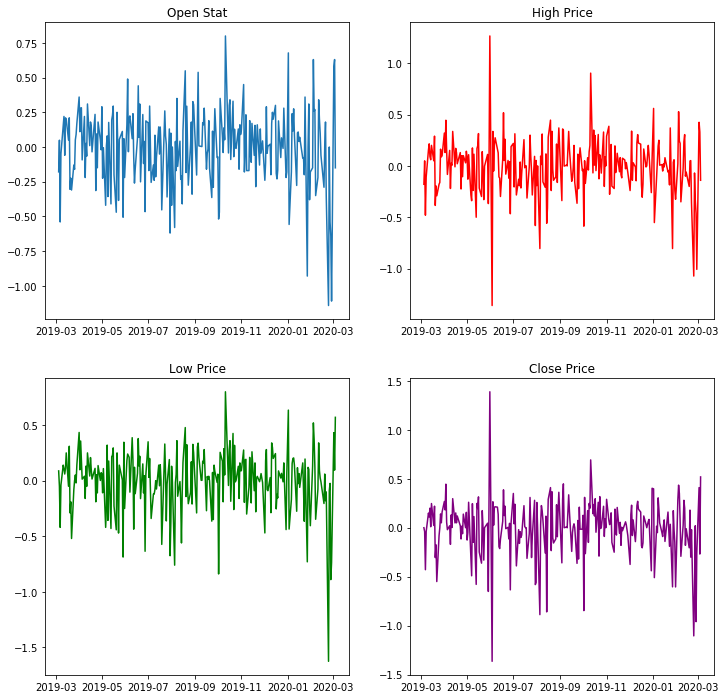

In [90]:
# plot de los datos estacionarios para DAX
fig, axes = plt.subplots(2,2, figsize=(12,12))
axes[0,0].plot(concat_data_DAX['Date'], concat_data_DAX['Open'])
axes[0,0].set_title('Open Stat')
axes[0,1].plot(concat_data_DAX['Date'], concat_data_DAX['High'], color='red')
axes[0,1].set_title('High Price')
axes[1,0].plot(concat_data_DAX['Date'], concat_data_DAX['Low'], color='green')
axes[1,0].set_title('Low Price')
axes[1,1].plot(concat_data_DAX['Date'],concat_data_DAX['Close'], color='purple')
axes[1,1].set_title('Close Price')
plt.savefig('../images/DAXStatdata.png')

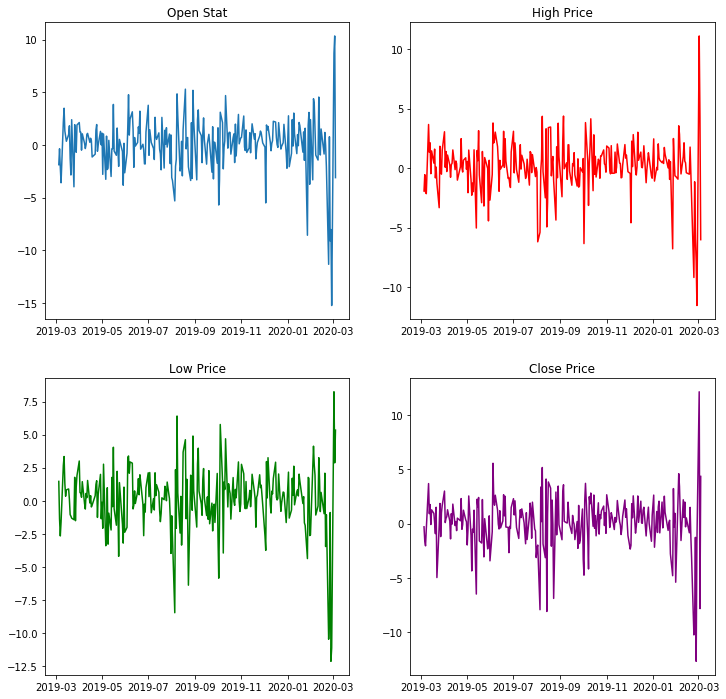

In [91]:
# plot de los datos estacionarios para VOO
fig, axes = plt.subplots(2,2, figsize=(12,12))
axes[0,0].plot(concat_data_VOO['Date'], concat_data_VOO['Open'])
axes[0,0].set_title('Open Stat')
axes[0,1].plot(concat_data_VOO['Date'], concat_data_VOO['High'],color='red')
axes[0,1].set_title('High Price')
axes[1,0].plot(concat_data_VOO['Date'], concat_data_VOO['Low'],color='green')
axes[1,0].set_title('Low Price')
axes[1,1].plot(concat_data_VOO['Date'],concat_data_VOO['Close'],color='purple')
axes[1,1].set_title('Close Price')
plt.savefig('../images/VOOStatdata.png')

In [92]:
concat_data_VOO

,Date,Open,High,Low,Close,Adj Close,Volume
1,2019-03-05,-1.880005,-1.929993,1.470002,-0.299987,-0.293930,-908300.0
2,2019-03-06,-0.369995,-0.550018,-1.360001,-1.640015,-1.606918,39000.0
3,2019-03-07,-2.139999,-2.019989,-2.650009,-2.049988,-2.008652,3926300.0
4,2019-03-08,-3.599991,-2.150009,-1.610001,-0.510010,-0.499725,-1918900.0
5,2019-03-11,2.159988,3.669998,2.680008,3.679993,3.605774,-2638100.0
...,...,...,...,...,...,...,...
249,2020-02-27,-8.039978,-7.799988,-12.120026,-12.679992,-12.679992,4663300.0
250,2020-02-28,-15.250000,-11.559998,-11.109985,-1.650025,-1.650025,8427100.0
251,2020-03-02,8.679993,11.119996,8.239990,12.130005,12.130005,-10895500.0
252,2020-03-03,10.339996,4.279998,2.869995,-7.829986,-7.829986,-2662200.0


In [93]:
concat_data_DAX = concat_data_DAX.set_index('Date')
concat_data_VOO = concat_data_VOO.set_index('Date')

# Train, test y test de causalidad de grangers

In [94]:
X_train_DAX = X_train_DAX.set_index('Date')

In [95]:
X_train_VOO = X_train_VOO.set_index('Date')

In [96]:
# Aplicando el test de causalidad de granger para ver si los datos se relacionan con su pasado
maxlag=12
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(concat_data_DAX, variables = concat_data_DAX.columns)        

,Open_x,High_x,Low_x,Close_x,Adj Close_x,Volume_x
Open_y,1.0000,0.0657,0.0000,0.0000,0.0000,0.0641
High_y,0.0016,1.0000,0.0000,0.0000,0.0001,0.1917
Low_y,0.0521,0.0241,1.0000,0.0700,0.0404,0.0572
Close_y,0.0003,0.0296,0.0000,1.0000,0.4655,0.1157
Adj Close_y,0.0032,0.1198,0.0003,0.3943,1.0000,0.0997
Volume_y,0.2989,0.2240,0.2351,0.4362,0.4263,1.0000


In [97]:
grangers_causation_matrix(concat_data_VOO, variables=concat_data_VOO.columns)

,Open_x,High_x,Low_x,Close_x,Adj Close_x,Volume_x
Open_y,1.0000,0.0000,0.0000,0.0000,0.000,0.0000
High_y,0.0011,1.0000,0.0000,0.0000,0.000,0.0070
Low_y,0.0003,0.0008,1.0000,0.0000,0.000,0.1057
Close_y,0.1035,0.0002,0.0130,1.0000,0.288,0.0615
Adj Close_y,0.1210,0.0004,0.0314,0.2926,1.000,0.0800
Volume_y,0.0000,0.0002,0.0001,0.0000,0.000,1.0000


# SMT Var prediction DAX

In [98]:
# El volumen es inverso a los valores de precio en los datos
mod_DAX = smt.VAR(concat_data_DAX)
res_DAX = mod_DAX.fit(maxlags=3)
print(res_DAX.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 04, Mar, 2020
Time:                     16:07:38
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -1.10571
Nobs:                     250.000    HQIC:                  -2.06521
Log likelihood:          -1675.47    FPE:                  0.0665545
AIC:                     -2.71150    Det(Omega_mle):       0.0428848
--------------------------------------------------------------------
Results for equation Open
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.000622         0.016053            0.039           0.969
L1.Open             -0.083201         0.213444           -0.390           0.697
L1.High             -0.782193         0.215237           -3.634  

In [99]:
# Durbin Watson Statistic 
out = durbin_watson(res_DAX.resid)
for col,val in zip(concat_data_DAX.columns,out):
    print((col), ':', round(val,2))

Open : 2.03
High : 2.02
Low : 1.96
Close : 2.01
Adj Close : 2.01
Volume : 2.06


In [100]:
# haciendo el forecast de los datos
pred_DAX = res_DAX.forecast(concat_data_DAX.values[-30:],30)
pred_df_DAX = pd.DataFrame(pred_DAX,index=concat_data_DAX.index[-30:],columns=concat_data_DAX.columns)
pred_df_DAX

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-22,0.236250,0.478722,-0.022053,0.271098,0.277128,-175.133169
2020-01-23,0.009215,-0.196099,-0.113627,-0.303074,-0.288241,6829.293265
2020-01-24,0.130525,0.117425,0.183891,0.202407,0.198591,-5405.854319
2020-01-27,-0.094121,-0.001740,-0.022649,0.006162,0.009317,-55.206785
2020-01-28,0.030726,-0.003047,-0.025093,-0.038516,-0.033473,1504.411291
2020-01-29,0.020362,0.004932,0.004080,0.015099,0.018675,1133.930249
2020-01-30,-0.011940,0.002727,0.018251,0.014717,0.015317,-2675.461096
2020-01-31,0.012392,0.009403,0.000451,-0.008162,-0.004792,1454.260676
2020-02-03,-0.003158,-0.004466,-0.007546,0.002051,0.005156,241.082377


In [101]:
# haciendo la suma acumulativa de los datos para volverlos no estacionarios de nuevo
pred_inverse_DAX = pred_df_DAX.cumsum()
pred_inverse_DAX

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-22,0.236250,0.478722,-0.022053,0.271098,0.277128,-175.133169
2020-01-23,0.245465,0.282624,-0.135680,-0.031976,-0.011113,6654.160096
2020-01-24,0.375990,0.400048,0.048211,0.170431,0.187477,1248.305778
2020-01-27,0.281869,0.398309,0.025562,0.176593,0.196795,1193.098993
2020-01-28,0.312595,0.395262,0.000469,0.138078,0.163322,2697.510284
2020-01-29,0.332957,0.400194,0.004549,0.153177,0.181997,3831.440533
2020-01-30,0.321017,0.402920,0.022800,0.167894,0.197314,1155.979437
2020-01-31,0.333408,0.412323,0.023251,0.159732,0.192522,2610.240113
2020-02-03,0.330251,0.407857,0.015705,0.161783,0.197678,2851.322490


In [102]:
X_test_DAX = X_test_DAX.set_index('Date')

In [103]:
# haciendo el forecast con los datos de test
f_DAX = pred_inverse_DAX + X_test_DAX
f_DAX = f_DAX.dropna()

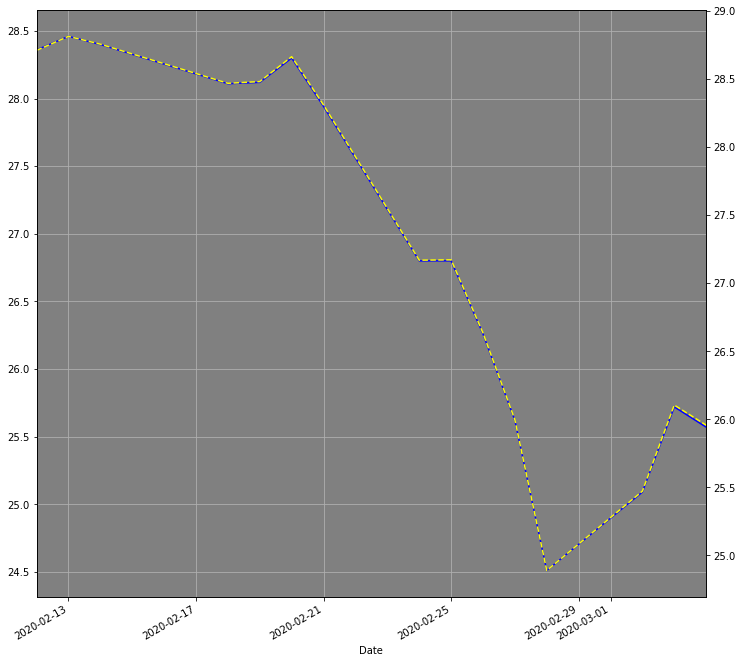

In [104]:
# Ploteo de la prediccion contra el real de los datos usando 15 dias
plt.figure(figsize=(12,12))
ax = plt.axes()
ax.set_facecolor('grey')
ax1= X_test_DAX.Open.plot(c='blue',grid=True, label='Open Price')
ax2= f_DAX.Open.plot(c='yellow', ls='--',grid=True,secondary_y=True,label='Precio Open Original')
plt.savefig('../images/RealvsPredDAX.png')
plt.show()

In [105]:
# muestra de los datos predecidos
f_DAX

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-02-12,28.710356,28.991476,28.282231,28.635861,28.690014,7306.809420
2020-02-13,28.812992,28.894548,28.308701,28.457874,28.514699,3188.995162
2020-02-14,28.755787,28.837233,28.300174,28.449798,28.509292,5013.867938
2020-02-18,28.468296,28.640175,28.096964,28.247351,28.309485,4897.715889
2020-02-19,28.480962,28.691149,28.158641,28.429548,28.494335,3689.600692
2020-02-20,28.663629,28.745995,27.980200,28.131677,28.199124,4194.567588
2020-02-21,28.308222,28.390895,27.880867,28.114002,28.184100,3287.924659
2020-02-24,27.168857,27.320829,26.257531,27.011257,27.084008,7281.734119
2020-02-25,27.171512,27.254712,26.169154,26.348448,26.423855,19281.348134


In [106]:
# evaluacion del forecast
forecast_errors = [X_test_DAX.Open[i]-f_DAX.Open[i] for i in range(len(X_test_DAX.Open))]
bias = sum(forecast_errors)* 1.0/len(X_test_DAX.Open)
print(bias)

-0.3688609260255324


In [107]:
mae = mean_absolute_error(X_test_DAX.Open,f_DAX.Open)
mse = mean_squared_error(X_test_DAX.Open, f_DAX.Open)
print('Mean abosolute error: ',mae,'mean squared error: ', mse )

Mean abosolute error:  0.3688609260255324 mean squared error:  0.13618806760270244


# SMT VAR para VOO

In [108]:
mod_VOO = smt.VAR(concat_data_VOO)
res_VOO = mod_VOO.fit(maxlags=3)
print(res_VOO.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 04, Mar, 2020
Time:                     16:07:39
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    27.5056
Nobs:                     250.000    HQIC:                   26.5461
Log likelihood:          -5251.89    FPE:                1.77391e+11
AIC:                      25.8999    Det(Omega_mle):     1.14303e+11
--------------------------------------------------------------------
Results for equation Open
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.043440         0.115854            0.375           0.708
L1.Open             -0.602012         0.155518           -3.871           0.000
L1.High             -0.141544         0.172121           -0.822  

In [109]:
X_train_VOO, X_test_VOO = VOO[0:-15], VOO[-15:]

In [110]:
X_test_VOO = X_test_VOO.set_index('Date')

In [111]:
out = durbin_watson(res_VOO.resid)
for col,val in zip(concat_data_VOO.columns,out):
    print((col), ':', round(val,2))

Open : 2.22
High : 2.17
Low : 2.07
Close : 1.97
Adj Close : 1.96
Volume : 2.13


In [112]:
pred_VOO = res_VOO.forecast(concat_data_VOO.values[-30:],30)
pred_df_VOO = pd.DataFrame(pred_VOO,index=concat_data_VOO.index[-30:],columns=concat_data_VOO.columns)
pred_df_VOO

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-22,0.254339,4.229626,0.423892,2.672105,2.669879,8.818154e+06
2020-01-23,-0.550040,1.086423,-2.496860,1.519079,1.368305,4.807638e+06
2020-01-24,4.131227,2.721092,3.718826,2.383387,2.542837,-5.639369e+06
2020-01-27,2.467509,-0.296274,0.406180,-3.363694,-3.302012,-3.088688e+06
2020-01-28,-2.682533,-1.810119,-0.020574,0.398840,0.366860,8.352179e+05
2020-01-29,-0.972761,0.710638,-0.340500,1.489099,1.492100,3.691209e+06
2020-01-30,0.264002,0.391463,-1.173046,-0.178013,-0.155966,1.103865e+06
2020-01-31,1.364334,0.519954,0.898343,0.138304,0.187776,-3.021787e+06
2020-02-03,0.724924,0.098028,0.859082,-0.515344,-0.486008,-1.272673e+06


In [113]:
pred_inverse_VOO = pred_df_VOO.cumsum()
pred_inverse_VOO

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-22,0.254339,4.229626,0.423892,2.672105,2.669879,8.818154e+06
2020-01-23,-0.295701,5.316050,-2.072968,4.191184,4.038184,1.362579e+07
2020-01-24,3.835526,8.037141,1.645858,6.574571,6.581021,7.986423e+06
2020-01-27,6.303035,7.740868,2.052038,3.210877,3.279010,4.897735e+06
2020-01-28,3.620502,5.930749,2.031464,3.609716,3.645870,5.732953e+06
2020-01-29,2.647741,6.641386,1.690964,5.098815,5.137970,9.424162e+06
2020-01-30,2.911743,7.032849,0.517918,4.920802,4.982003,1.052803e+07
2020-01-31,4.276077,7.552803,1.416261,5.059106,5.169780,7.506239e+06
2020-02-03,5.001002,7.650832,2.275344,4.543763,4.683772,6.233567e+06


In [114]:
f_VOO = pred_inverse_VOO + X_test_VOO
f_VOO = f_VOO.dropna()

In [115]:
f_VOO

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-02-12,314.018989,318.393690,311.484143,315.917606,316.171798,1.090193e+07
2020-02-13,313.514421,319.216153,310.803446,315.763489,316.042843,1.049863e+07
2020-02-14,315.450833,318.987694,311.791195,316.246858,316.552218,9.460868e+06
2020-02-18,314.593339,318.464881,311.024231,315.438179,315.762479,1.084254e+07
2020-02-19,315.614018,320.280296,313.075314,317.128827,317.467852,1.061484e+07
2020-02-20,315.629924,320.092029,309.614295,316.136796,316.494766,1.319653e+07
2020-02-21,313.900490,317.718337,308.731300,313.028878,313.410455,1.099372e+07
2020-02-24,302.788138,308.636294,298.506729,302.817032,303.220879,1.516032e+07
2020-02-25,303.577977,307.542596,289.817514,294.023672,294.445923,1.664655e+07


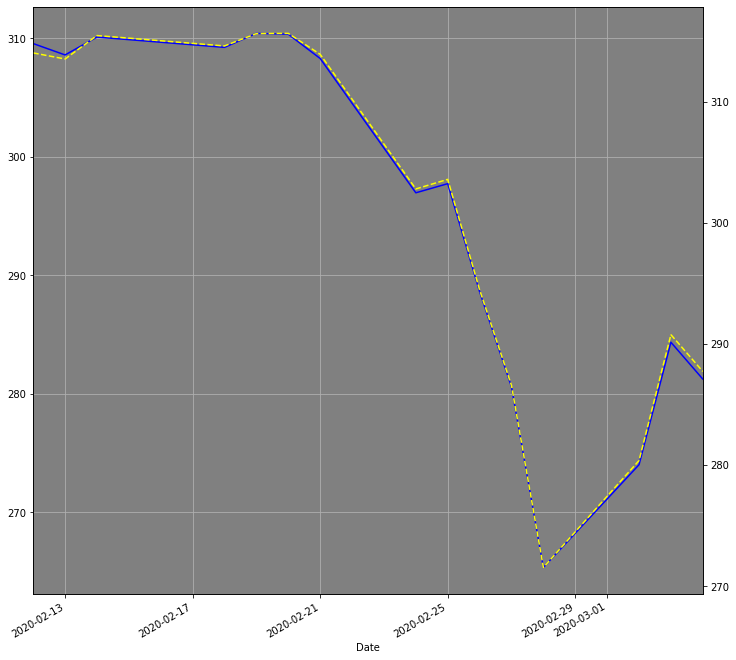

In [116]:
fig = plt.figure(figsize=(12,12))
ax = plt.axes()
ax.set_facecolor('grey')
ax1= X_test_VOO['Open'].plot(c='blue',grid=True, label='Open Price')
ax2= f_VOO.Open.plot(c='yellow', ls='--',grid=True,secondary_y=True,label='Precio Open Original')
plt.savefig('../images/RealvsPredVOO.png')
plt.show()

In [117]:
forecast_errors = [X_test_VOO.Open[i]-f_VOO.Open[i] for i in range(len(X_test_VOO.Open))]
bias = sum(forecast_errors)* 1.0/len(X_test_VOO.Open)
print(bias)

-5.676358951083474


In [118]:
mae = mean_absolute_error(X_test_VOO.Open,f_VOO.Open)
mse = mean_squared_error(X_test_VOO.Open, f_VOO.Open)
print('Mean abosolute error: ',mae,'mean squared error: ', mse )

Mean abosolute error:  5.676358951083474 mean squared error:  32.543352496138745
